# Importing Libraries and Pre-Processing

In [10]:
### Importing Libraries
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling libraries
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline

# Preprocessing and cross-validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, RepeatedKFold

# Model saving
import pickle

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import Normalize

import timeit
from datetime import timedelta

plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'

In [11]:
### Importing and Preparing Data
# load dataset
training_data = pd.read_csv('train_x.csv').to_numpy()
training_label = pd.read_csv('train_y.csv').to_numpy().flatten()
testing_data = pd.read_csv('test_x.csv').to_numpy()
testing_label = pd.read_csv("test_y.csv").to_numpy().flatten()

print(f'Full train data: X = {training_data.shape}, y = {training_label.shape}')
print(f'Full test data:  X = {testing_data.shape}, y = {testing_label.shape}')

Full train data: X = (50000, 32, 32, 3), y = (50000,)
Full test data:  X = (10000, 32, 32, 3), y = (10000,)


In [12]:
full_train_data = np.reshape(training_data, (training_data.shape[0], 32, 32, 3))
test_data = np.reshape(testing_data, (testing_data.shape[0], 32, 32, 3))
full_train_label = training_label
test_label = testing_label
print(f'Full train data: X = {full_train_data.shape}, y = {full_train_label.shape}')
print(f'Full test data:  X = {test_data.shape}, y = {test_label.shape}')

Full train data: X = (50000, 32, 32, 3), y = (50000,)
Full test data:  X = (10000, 32, 32, 3), y = (10000,)


In [13]:
# Histogram of Oriented Gradients
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

def extract_hog(data):
    fd_array = np.empty(shape=(len(data), 3780), dtype='float')
    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd = hog(resized_img, orientations=9, pixels_per_cell=(8,8), 
                 cells_per_block=(2,2), visualize=False, multichannel=True, 
                 block_norm='L2-Hys')
        fd_array[i] = fd
    return fd_array

In [15]:
tic = timeit.default_timer()
full_train_data_hog = extract_hog(full_train_data)
test_data_hog = extract_hog(test_data)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}")

time elapsed: 0:05:41.142814


In [16]:
# Training and Validation Set Split
train_data_hg, val_data_hg, train_label, val_label = train_test_split(
    full_train_data_hog, full_train_label, test_size = 0.3,
    stratify = full_train_label, random_state = 40)
print(f'Train data:       X = {train_data_hg.shape}, y = {train_label.shape}')
print(f'Validation data:  X = {val_data_hg.shape}, y = {val_label.shape}')

Train data:       X = (35000, 3780), y = (35000,)
Validation data:  X = (15000, 3780), y = (15000,)


In [17]:
# Dimensionality Reduction - PCA
pca_scaled2 = make_pipeline(StandardScaler(), 
                           PCA(n_components = 0.8, whiten=True, random_state=0))
tic = timeit.default_timer()
X_train_hg = pca_scaled2.fit_transform(train_data_hg)
X_val_hg = pca_scaled2.transform(val_data_hg)
toc = timeit.default_timer()
print(f"time elapsed:              {timedelta(seconds=toc-tic)}")
print(f"PCA train data shape:      {X_train_hg.shape}")
print(f"PCA validation data shape: {X_val_hg.shape}")

time elapsed:              0:01:49.957988
PCA train data shape:      (35000, 460)
PCA validation data shape: (15000, 460)


# Classification

### Logistic Regression

In [25]:
# GridSearch Search with several parameters using training data
C = [int(x) for x in np.logspace(-1, 3, num = 5)]
fit_intercept = [True, False]
parameters = {
 'C': C,
 'fit_intercept': fit_intercept
 }

In [27]:
lr = LogisticRegression()
lr_grid = GridSearchCV(
    estimator = lr, param_grid = parameters, cv = 4, verbose = 2, n_jobs = -1)
tic = timeit.default_timer()
lr_grid.fit(X_train_hg, train_label)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   26.8s finished


time elapsed: 0:00:29.767536


In [28]:
lr_results = pd.DataFrame(lr_grid.cv_results_)
print(lr_grid.best_params_)
print(lr_grid.best_score_)                  # 0.5223142857142857
print(lr_grid.score(X_val_hg, val_label))  # 0.5415333333333333
# 

{'C': 1, 'fit_intercept': True}
0.5223142857142857
0.5415333333333333


In [29]:
# Building a model with all the training and validation data and testing with test data
pca_pipe = make_pipeline(PCA(n_components=0.8, whiten=True, random_state=0))
lrmod = LogisticRegression(C=1, fit_intercept=True)
lr_pipe = make_pipeline(pca_pipe, lrmod)
tic = timeit.default_timer()
lr_pipe.fit(full_train_data_hog, full_train_label)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}") # 1149.32 seconds

time elapsed: 0:02:51.082740


In [30]:
print(f"Train accuracy: {lr_pipe.score(full_train_data_hog, full_train_label)}") # 0.54794
print(f"Test accuracy:  {lr_pipe.score(test_data_hog, test_label)}")             # 0.5313

Train accuracy: 0.54794
Test accuracy:  0.5313


In [31]:
# Model prediction
pred = lr_pipe.predict(test_data_hog)

Accuracy: 0.531
Confusion matrix:
[[573  30  74  17  66  11  35  21 146  27]
 [ 34 698   9  14  13   4  47   9  62 110]
 [ 74  12 411  70 117 118  86  42  52  18]
 [ 35  28 109 280 141 143 127  58  31  48]
 [ 70  17 120  84 455  59  61  84  33  17]
 [ 15   7 125 126  79 407  97  96  22  26]
 [ 30  25  86  73  45  58 620  20  32  11]
 [ 23  15  51  44  74  82  26 635  15  35]
 [135  77  29   7  30   8  32  13 603  66]
 [ 44  97  11  27  25  23  18  55  69 631]]


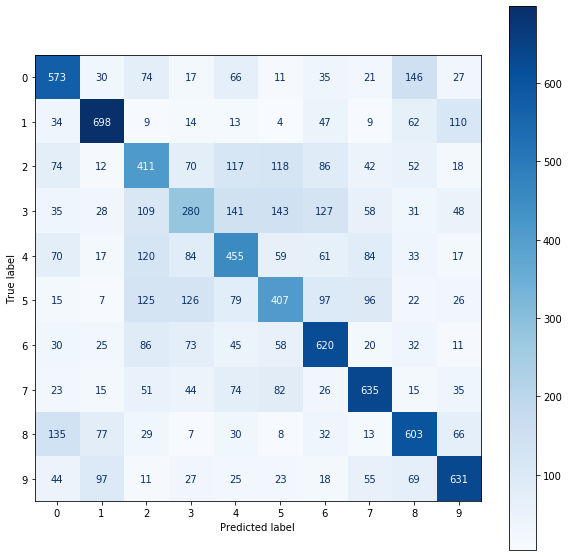

In [32]:
print(f"Accuracy: {accuracy_score(test_label, pred):.3f}")
print(f"Confusion matrix:\n{confusion_matrix(test_label, pred)}")
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(confusion_matrix(test_label, pred), 
                       display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']).plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
plt.savefig("confusion_lr.png")

In [33]:
# Classification report
print(classification_report(test_label, pred))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1000
           1       0.69      0.70      0.70      1000
           2       0.40      0.41      0.41      1000
           3       0.38      0.28      0.32      1000
           4       0.44      0.46      0.44      1000
           5       0.45      0.41      0.43      1000
           6       0.54      0.62      0.58      1000
           7       0.61      0.64      0.62      1000
           8       0.57      0.60      0.58      1000
           9       0.64      0.63      0.63      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



In [34]:
# Save model file with pickle
lr_pickle = "Pickle_LR_hfull.pkl"  

with open(lr_pickle, 'wb') as file:  
    pickle.dump(lr_pipe, file)

In [5]:
# Load model from file with pickle
lr_pickle = "Pickle_LR_hfull.pkl" 
with open(lr_pickle, 'rb') as file:  
    pickled_lr = pickle.load(file)

pickled_lr

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=100, random_state=0,
                                      svd_solver='auto', tol=0.0,
                                      whiten=True))],
                          verbose=False)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(l2_regularization=1,
                                                learning_rate=0.1, loss='auto',
                                                max_bins=255, max_depth=10,
                                                max_iter=2000,
                             